# Coursera Capstone

Introduction:
In this capstone, I will compare several neighborhoods in Frankfurt am Main to the neighborhood of Five Points, Denver, to determine which are most similar, and which are most different. I will base the comparison on foursquare API data from each neighborhood to compare amenities in each neighborhood. 

Data:
I will be using the following Foursquare API data to compare the selected neighborhoods. Since I am comparing 5 similar neighborhoods to a single disparate neighborhood, k means clustering will not be a viable means of analysis. Instead, I will utilize a pairwise distance matrix to compare each neighborhood to the others. This will necessitate a numerical value for the data rather than string categories. Thus, I will use the onehot dataframe, indexed by the neighborhood names(hoodcomp_pdm), to perform the analysis.

In [9]:
#import pandas
import pandas as pd
import numpy as np
! pip install geopy
!pip install folium
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
#create data frame containing names and location data for the two neighborhoods to be compared
hoods = [['Five Points','39.75472','-104.97806'],
         ['Bockenheim','50.12498','8.64538'],
         ['Innenstadt','50.11029','8.68417'],
         ['Westend','50.11651','8.66375'],
         ['Sachsenhausen','50.1008','8.68556'],
         ['Bornheim','50.13135', '8.71251'],
         ['Nordend','50.12988', '8.67946'],
         ]
hoodcomp = pd.DataFrame(hoods, index=[0, 1,2,3,4,5,6], columns=['Neighborhood', 'Latitude', 'Longitude'])
hoodcomp
CLIENT_ID = 'FTIRR55RB4P1OQXANB0D0SQFSFW1FR02DYJH52VQWWZZXXWY' # your Foursquare ID
CLIENT_SECRET = 'QUP2H2VA23RUES5EXFMTKXLSJM4IISLP15OHT23HYVBCBM3B' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
hoodcomp.columns=['Neighborhood','Latitude','Longitude']
hoodcomp

#Get request URL
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url
#obtain and label lat/long of the first neighborhood(s)
neighborhood_latitude = hoodcomp.loc[0, 'Latitude']
neighborhood_longitude = hoodcomp.loc[0, 'Longitude']

neighborhood_name = hoodcomp.loc[0, 'Neighborhood']

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
#Get request URL
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url
#results of get request
results = requests.get(url).json()

#obtain venue categories
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
#convert results to dataframe
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
# formula to obtain venues in all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# run formula for each neighborhood
hoodcomp_venues = getNearbyVenues(names=hoodcomp['Neighborhood'],
                                   latitudes=hoodcomp['Latitude'],
                                   longitudes=hoodcomp['Longitude']
                                  )
#onehot encoding
hoodcomp_onehot = pd.get_dummies(hoodcomp_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hoodcomp_onehot['Neighborhood'] = hoodcomp_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hoodcomp_onehot.columns[-1]] + list(hoodcomp_onehot.columns[:-1])
hoodcomp_onehot = hoodcomp_onehot[fixed_columns]

hoodcomp_onehot.head()
hoodcomp_grouped = hoodcomp_onehot.groupby('Neighborhood').mean().reset_index()
hoodcomp_grouped
#the pairwise distance matrix cannot parse the neighborhood str, so i set the neighborhood names as the df index
hoodcomp_pdm=hoodcomp_grouped.set_index("Neighborhood")
hoodcomp_pdm


Your credentails:
CLIENT_ID: FTIRR55RB4P1OQXANB0D0SQFSFW1FR02DYJH52VQWWZZXXWY
CLIENT_SECRET:QUP2H2VA23RUES5EXFMTKXLSJM4IISLP15OHT23HYVBCBM3B
Latitude and longitude values of Five Points are 39.75472, -104.97806.


<ipython-input-9-9a6af9886e26>:88: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


Five Points
Bockenheim
Innenstadt
Westend
Sachsenhausen
Bornheim
Nordend


,Wine Bar,ATM,Apple Wine Pub,Art Museum,Arts & Crafts Store,Asian Restaurant,Austrian Restaurant,Bagel Shop,Bakery,Bank,...,Spanish Restaurant,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Bockenheim,0.048780,0.000000,0.000000,0.000000,0.02439,0.073171,0.000000,0.000000,0.024390,0.024390,...,0.048780,0.000000,0.024390,0.000000,0.024390,0.024390,0.000000,0.048780,0.000000,0.024390
Bornheim,0.034483,0.000000,0.034483,0.000000,0.00000,0.000000,0.000000,0.000000,0.034483,0.000000,...,0.034483,0.000000,0.034483,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000
Five Points,0.000000,0.052632,0.000000,0.000000,0.00000,0.000000,0.000000,0.052632,0.052632,0.052632,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Innenstadt,0.012987,0.000000,0.000000,0.064935,0.00000,0.000000,0.012987,0.000000,0.012987,0.000000,...,0.000000,0.000000,0.000000,0.012987,0.012987,0.000000,0.000000,0.012987,0.012987,0.012987
Nordend,0.000000,0.000000,0.000000,0.000000,0.00000,0.066667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667
Sachsenhausen,0.023810,0.000000,0.071429,0.000000,0.00000,0.023810,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.023810,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.047619
Westend,0.000000,0.000000,0.000000,0.000000,0.00000,0.071429,0.000000,0.000000,0.071429,0.000000,...,0.000000,0.142857,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


now that we have obtained the onehot data, we will use it to create the pairwise distance matrix. Keep in mind, the LOWER the distance, the MORE SIMILAR the two rows being compared!

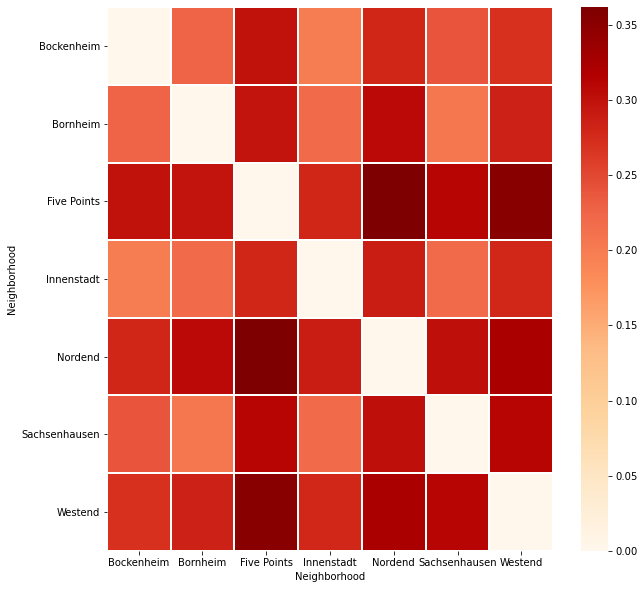

In [10]:
#import the pdist function form scipy and compare the rows of the onehot dataframe
from scipy.spatial.distance import pdist
pdist(hoodcomp_pdm.loc[['Five Points','Bockenheim','Innenstadt','Westend','Sachsenhausen','Bornheim','Nordend']])
#these results aren't easy to interpret, so I convert them to a labled df using squareform from scipy
from scipy.spatial.distance import squareform

squareform(pdist(hoodcomp_pdm.loc[['Five Points','Bockenheim','Innenstadt','Westend','Sachsenhausen','Bornheim','Nordend']]))

pd.DataFrame(
    squareform(pdist(hoodcomp_pdm)),
    columns = hoodcomp_pdm.index,
    index = hoodcomp_pdm.index
)
import seaborn as sns
import matplotlib.pyplot as plt

# make summary table for just top countries


# make pairwise distance matrix
pairwise_top = pd.DataFrame(
    squareform(pdist(hoodcomp_pdm)),
    columns = hoodcomp_pdm.index,
    index = hoodcomp_pdm.index
)


# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise_top,
    cmap='OrRd',
    linewidth=1
)

As we can see, the neighborhood most closely resembling five points is Innenstadt! Bockenheim, Bornheim, and Sachsenhausen might make good places to live as well, while Nordend and Westend probably wouldn't be to my tastes, given how much I enjoy living in Five Points. 